<a href="https://colab.research.google.com/github/arielmeragelman/procesamientodevozenwhatsapp/blob/main/Proyecto_procesamiento_de_voz_whatsapp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

El siguiente informe se dedicará a describir el proceso de investigación realizado para el desarrollo de un sistema automático de búsqueda inteligente de texto en archivos de audio de whatsapp.


Para esto partimos del esquema de lo que tenemos disponible y el resultado final que esperamos obtener.

-Partiendo de la estructura de archivos de audio que tiene whatsapp en un celular se encuentra que los mismos están localizados dentro de whatsap voice notes en carpetas numeradas con un índice que se relaciona de forma única con el "chat" al cual pertenecen, por lo que es necesario conservar la información de dicha estructura de datos a fin de mantener la identidad de los archivos de audio.

Estos archivos se encuentran en un formato opus,  el cual es un codec abierto y podremos transformar sin mayor dificultad y sin pérdidas a formato wav para su posterior uso.


Así es que utilizamos el método Audiosegment de la librería  pydub para la conversión de los archivos (los mismos ya previamente descargados como copia  en nuestro entorno de trabajo).


Posteriormente pasamos a la etapa de conversión de audio a texto,  para esto utilizamos la librería speech_recognition 


*Zhang, A. (2017). Speech Recognition (Version 3.8) [Software]. Available from https://github.com/Uberi/speech_recognition#readme*

En donde deberemos instanciar un objeto de la clase Recognizer para luego con los métodos record y recognize_google (para configurar el idioma a convertir) realizar la extracción de texto propiamente dicha.


Para la versión actual del proyecto creamos una base de datos sqlite debido a la simpleza de la misma que alcanza para las funciones que vamos a llevar a cabo.


La base de dato deberá poder llevar un registro ordenado del nombre de los archivos de audio,  el índice (carpeta ) de los mismos, el path completo con su nombre, los metadatos asociados a la fecha de creación, el texto obtenido por la librería speech_recognition previamente vista.

 - En una próxima etapa del proyecto,  el cual no se llegó a desarrollar aún, está la idea de poder guardar en la base de datos los valores de los vectores que conforman los textos para una búsqueda semántica. Para esto se deberá evaluar si es posible seguir trabajando con sqlite o será necesario migrar a otra base de datos incluso nosql.

# Primer Etapa
Conversion de Audio a Texto

In [ ]:
# Realizamos la instalacion de las librerias necesarias
!pip install pydub
!pip install SpeechRecognition

Definimos funciones auxiliares para la conversion


In [ ]:
def ogg2wav(ofn : str) -> str:
  #Funcion para convertir archivos ogg de whatsapp a wav
  try:
    from pydub import AudioSegment    
    try:
      print(f"tipo de archivo audio entrada: {type(ofn)}")
      wfn = ofn.replace('.ogg','.wav')
      x = AudioSegment.from_file(ofn)
      x.export(wfn, format='wav')
      
      print(f"se convirtio el archivo {ofn} a {wfn}")
    except:
      print("No se pudo convertir ogg a wav")
      return "0"
    
    try:
      os.remove(ofn) 
      print(f"!!! Se pudo eliminar el archivo {ofn}")
    except:
      print(f"!!! No se pudo eliminar el archivo {ofn}")

    return wfn
  
  except:
    return "0"


def copiar_archivos(directorio_in : str, directorio_out : str, yacopiado : list ) -> list :
  # Funcion para copiar los archivos ogg del celular a un directorio
  
  import os
  archivos_nuevos=[]
  registros_bbdd=[]
  
  print(f"Directorio_in es {directorio_in}")  
  for i in os.listdir(directorio_in):
    print(f"El directorio i es: {i}")
    

    if not os.path.exists(directorio_out+i):
      print(f"se crea directorio {directorio_out+i}")
      os.makedirs(directorio_out+i)
    
    for j in os.listdir(directorio_in+"/"+i):
      if (j[-3:]=="ogg" or j[-4:]=="opus" )   :
        print(f"se detecta archivo {j}")
        if ((i+"/"+j) in yacopiado):
          print("se ignora por estar en yacopiado")
          pass
        else:
          ubic_archivo=i+"/"+j
          import shutil
          shutil.copy2(directorio_in+"/"+i+"/"+j, directorio_out+i+"/"+j)
          
          registros_bbdd.append( (i,ubic_archivo,j[4:12])  )
      else:
        print(f"el archivo no tiene la extension requerida no se copia {j}")
    


  return registros_bbdd

def convertir_en_texto(archivo,idioma="es-ES") -> str:
  # Funcion para convertir un archivo de audio en texto
  import speech_recognition as sr 
  import os
  archivo = ogg2wav(archivo)
  print(f"tipo de archivo {type(archivo)}")
  re = sr.Recognizer()

  # Abro el archivo de audio ya transformado, lo utilizo como argumento de entrada para el metodo de speech_recognition
  # De esta manera creamos un objeto que puede ser convertido usando el motor de google
  with sr.AudioFile(archivo) as source:
    info_audio = re.record(source)
    texto = re.recognize_google(info_audio, language =idioma)
  print(texto)
  os.remove(archivo)
  
  return texto

Definimos las funciones auxiliares para la creacion y manejo de la base de dato

In [ ]:
# 
def crear_tablas() -> int :
  # funciones para crear las tablas y la base de dato
  import sqlite3
  
  try:
    conexion=sqlite3.connect("bd1.db")
  except:
    print("No se pudo establecer conexion con la bbdd")
    return 0

  try:
      conexion.execute("""create table audios (
                                codigo integer,
                                ubicacion text primary key,
                                fecha int,
                                texto text
                          )""")
      print("se creo la tabla audios")                        
      return 1
  except sqlite3.OperationalError:
      print("La tabla audios ya existe")                    
      return 0
  conexion.close()


def insertar_registro(a : tuple) -> int :
  # Funcion para insertar un registro a la base de datos
  import sqlite3
  try:
    conexion=sqlite3.connect("bd1.db")
  except:
    print("No se pudo establecer la conexion con la BBDD")
    return 0
  try:  
    conexion.execute("insert into audios(codigo,ubicacion,fecha,texto) values (?,?,?,?)", (a[0], a[1], a[2], a[3]))
    conexion.commit()
  except Exception as a:
    print(f" No se pudo insertar el registro, error: {a}")
  finally:  
    conexion.close()


def buscar_registro(query : str) -> int :
  #Funcion para realizar busquedas sql dentro de la base
  import sqlite3
  try:
    conexion=sqlite3.connect("bd1.db")
  except:
    print("No se pudo establecer la conexion con la BBDD")
    return 0
  try:  
    cursor = conexion.execute(f"select codigo,ubicacion,fecha,texto from audios where {query} ")
    filas=cursor.fetchall()
    if len(filas)>0:
      for fila in filas:
        print(fila)
      return filas
    else:
      print("No se encontraron registros")

  except Exception as a:
    print(f" No se pudo consultar el registro, error: {a}")
  finally:  
    conexion.close()

def buscar_repetidos() -> list :
  # Funcion para listar todos los registros de audios que se han guardado en la bbdd
  # La idea de esta funcion es tener un indice de los archivos de audios que ya fueron convertidos

  import sqlite3
  try:
    conexion=sqlite3.connect("bd1.db")
  except:
    print("No se pudo establecer la conexion con la BBDD")
    return 0
  try:  
    cursor = conexion.execute(f"select ubicacion from audios where 1 ")
    filas=cursor.fetchall()
    if len(filas)>0:
      return filas
    else:
      print("No se encontraron registros")

  except Exception as a:
    print(f" No se pudo consultar el registro, error: {a}")
  finally:  
    conexion.close()

def crear_directorios() -> int:
  import os
  try:
    os.mkdir("audios_temporales")
    return 1
  except:
    print("No se pudo crear el directorio")
    return 0

def conversor_registra(listado : list, idioma=None ) -> int :
  #  Funcion para convertir y guardar en la bbdd todos los registros nuevos

  if (len(listado) > 0 and (type([]) == list) ) :
    for registro in listado:
      texto = convertir_en_texto("audios_temporales/"+registro[1],idioma)
      insertar_registro((registro[0],registro[1],registro[2],texto))
  else: 
    print("No hay registros para transformar")


Iniciamos la ejecución del entorno de prueba con la creación del mismo

In [ ]:
# Se crean las tablas
crear_tablas()

# Se crean directorios
crear_directorios()



Se crea una carpeta temporal sobre Google Drive para realizar las pruebas de ejecución del entorno de prueba, estos pasos se omitiran una vez que el programa se ejecute en un entorno de producción con una estructura de archivos ya definidas (eventualmente se podria mantener esta estructura pero para esto se deberian subir manualmente la carpeta completa de audio de whatsapp cada vez que se quiera realizar el proceso de ejecución)

In [ ]:
# TEMPORALMENTE SE REALIZARA UN MONTAJE DE LOS ARCHIVOS QUE SE UTILIZARAN HASTA QUE SE DEFINA UNA ESTRUCTURA LOCAL PARA TRABAJAR
from google.colab import drive
drive.mount('/content/MyDrive')


In [ ]:
# Se determina si de la lista de archivos obtenidos hay algunos ya copiados
archivos_viejos=buscar_repetidos()


if not archivos_viejos:
  # Si no hay duplicidad de registros en la bbdd se utilizara una lista falza o dummy para continuar con la ejecución
  archivos_viejos=["a","b"]

archivos_viejos =[b[0] for b in archivos_viejos]
try:
  if len(archivos_viejos) > 1:
    # Si se detecta duplicidad de archivos se ignoran los mismos
    print("||||||||||||||||| SE ENCONTRARON ARCHIVOS EN LA BBDD ||||||")
    
    
    print(archivos_viejos[2])
except:
  archivos_viejos=["a","b"]
finally:
  # Se ejecuta una copia de los archivos de audio a la nueva estructura de directorios
  # Durante el pase a producción el primer argumento de esta funcion debera ser la carpeta donde se monten las notas de audio de whatsapp del celular
  registros = copiar_archivos("MyDrive/MyDrive/audios_test", "audios_temporales/", archivos_viejos )
# Ejecutamos la conversion de audio a texto
  conversor_registra(registros,"es-ES")

In [ ]:
# Se verifica que se pudo realizar correctamente la conversion y que se guardaron los resultados en la bbdd
listado=buscar_registro("1")

# SEGUNDA ETAPA
Una vez almacenados los textos con su correspondiente metadata en una base de dato pasamos a desarrollar una herramienta para la consulta y busqueda de información.
Partimos de la idea que buscamos información a partir de información y no buscamos datos a partir de datos. Es por esto que trabajamos bajo el concepto de analisis semantico, es decir contextual

In [ ]:
# Inicia proceso de busqueda semantica

# Creamos un dataframe con la información que tiene la bbdd para poder trabajar de una forma mas simple en una primera instancia exploratoria
# En una siguiente etapa no seria requerido crear un dataframe ya que se podria trabajar directamente sobre la base de datos
import pandas as pd
import numpy as np

df = pd.DataFrame(listado)
df[3]=df[3].str.strip()





SE REALIZA UNA PRUEBA DE BUSQUEDA SEMANTICA CON txtai

[Repo del proyecto](https://github.com/neuml/txtai)


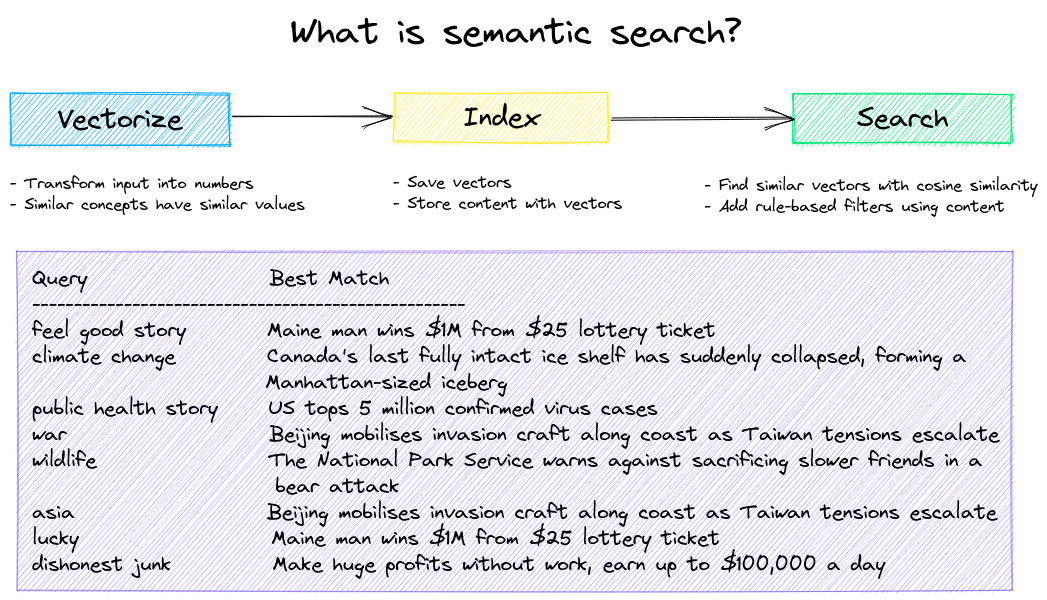

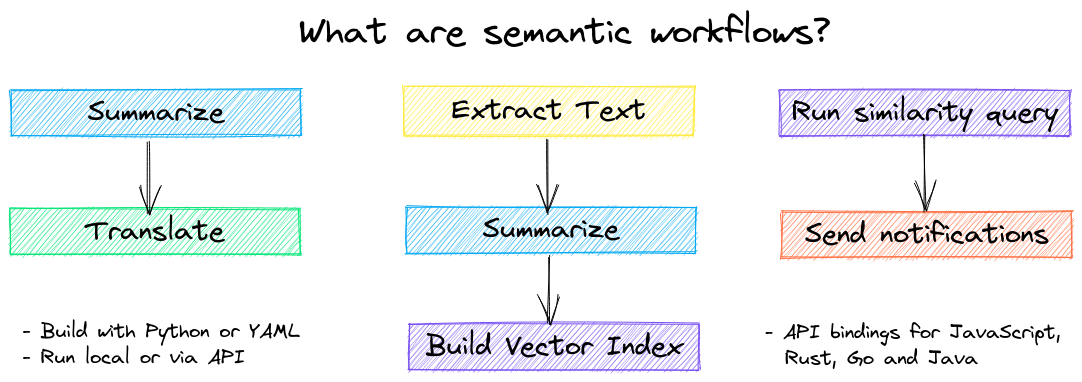

Los modelos de txtai estan parametrizados en ingles, por lo que para poder utilizar estos modelos vamos a tener que convertir los textos al ingles, para esto usamos la libreria translators.

[Repositorio](https://github.com/UlionTse/translators)




In [ ]:
# instalamos librerias para traduccion de texto y de busqueda semantica
!pip install txtai
!pip install translators

In [ ]:
#Se desarrolla una solucion de traduccion de español a ingles usando la libreria translators

def traducir1(lista_entrada : list) -> list:
  # Funcion para convertir una lista de textos en español a una lista de textos en ingles
  import translators as trs
  lista_salida=[]
  for linea in lista_entrada:
    lista_salida.append((trs.translate_text(linea, translator='google', to_language='en')))
  return lista_salida


Procedemos a evaluar el funcionamiento del traductor
Para esto realizamos pruebas con distintas listas de palabras y distintas listas de oraciones

In [ ]:

print(traducir1(["hola","pez"]))
print(traducir1(["juan me saludo y yo le dije,hola!","en el mar es facil encontrar un pez"]))
print(traducir1(["casa","linea"]))
print(traducir1(["mi casa es grande","linea"]))
print(traducir1(["perro","Heladera"]))
print(traducir1(["en la cucha de mi perro","la heladera esta vacia"]))

Encontramos que de forma aleatorea la libreria translate tira errores "TypeError: the JSON object must be str, bytes or bytearray, not NoneType" Pero este error es aleatoreo y en ejecuciones consecutivas da distinto resultado. Por lo que probamos otra libreria como deep-translator

La Libreria deep-translator puede encontrarse en

[Repositorio](https://github.com/nidhaloff/deep-translator)

Segun la documentación oficial

**When you should use it**

If you want to translate text using python

If you want to translate from a file

If you want to get translations from many sources and not only one

If you want to automate translations

If you want to use ChatGpt for translations

If you want to compare different translations


If you want to detect language automatically


**Why you should use it**

It's the only python tool that integrates many translators

Multi language support

Support for ChatGpt (version >= 1.11.0)

Supports batch translation


High level of abstraction

Automatic language detection

Easy to use and extend

Support for most famous universal translators

Stable and maintained regularly

The API is very easy to use

Proxy integration is supported



In [ ]:
# Instalamos la libreria
!pip install -U deep-translator

In [ ]:
# Se desarrolla otra alternativa de traduccion de español al ingles usando deep_translator
def traducir2(lista_entrada):
  
  from deep_translator import GoogleTranslator
    
  lista_salida=[]
  for linea in lista_entrada:
    lista_salida.append(GoogleTranslator(source='auto', target='en').translate(linea))
  return lista_salida


Volvemos a simular la mismas pruebas que antes con esta nueva libreria y conseguimos un resultado exitoso

In [ ]:

print(traducir2(["hola","pez"]))
print(traducir2(["juan me saludo y yo le dije,hola!","en el mar es facil encontrar un pez"]))
print(traducir2(["casa","linea"]))
print(traducir2(["mi casa es grande","linea"]))
print(traducir2(["perro","Heladera"]))
print(traducir2(["en la cucha de mi perro","la heladera esta vacia"]))

Encontramos que el modelo de traducción que utiliza el sistema es semantico, es decir que funciona mejor cuando se entrega contexto a las palabras y no se utiliza para traducir una palabra en particular.
Asi podemos ver como una misma palabra suelta no puede ser traducida, mientras que puesta dentro del contexto de una oración el sistema funciona correctamente

Creamos una prueba de funcionalidad con datos controlados

In [ ]:

from txtai.embeddings import Embeddings

# Create embeddings model, backed by sentence-transformers & transformers
embeddings = Embeddings({"path": "sentence-transformers/nli-mpnet-base-v2"})

# generamos un set de datos de prueba para evaluar el modelo
data = ["En una carrera de trail lo principal es controlar la energia y la ansiedad",
        "El lunes el ale me pidio un informe sobre el pautado de abril",
        "Ana me dijo que tenemos que comprar queso",
        "correr en auto es un deporte muy peligroso, no deberias hacerlo",
        "por un ataque informatico se dio una corrida bancaria",
        "los sandwiches de milanesa mas ricos son los de ana"]

data=traducir2(data)

# Create an index for the list of text
embeddings.index([(uid, text, None) for uid, text in enumerate(data)])




Guardamos el indice de embeddings creado y lo leemos nuevamente para ejecutar las primeras pruebas

In [ ]:
# Grabamos el indice para utilizarlo en otro momento
embeddings.save("index")

# cargamos los indices para su uso
embeddings.load("index")

buscar=traducir2(["comprar"])

# Definimos que debe mostrar las principales 5 oraciones con un match mas alto segun el calculo realizado.
uid = embeddings.search(buscar, 5)
for i in uid:
  print(data[i[0]])

Ejecutamos una bateria de pruebas de busqueda

In [ ]:
buscar=traducir2(["comprar en el super"])
uid = embeddings.search(buscar, 5)
for i in uid:
  print(data[i[0]])
print("----")

buscar=traducir2(["datos sobre"])
uid = embeddings.search(buscar, 1)
for i in uid:
  print(data[i[0]])
print("----")

buscar=traducir2(["comprar queso"])
uid = embeddings.search(buscar, 1)
for i in uid:
  print(data[i[0]])

Por lo que podemos ver con las primeras pruebas, es muy importante para que funcione la busqueda semantica dar un contexto a las palabras buscadas, es decir no utilizar solo una palabra aislada

Intentamos convertir la informacion del dataframe en una lista para repetir la prueba anterior, en una etapa posterior se podria trabajar directamente generando una consulta SQL que traiga la columna de interes


In [ ]:
list_of_single_column = list(df[3])


In [ ]:
data=traducir2(list_of_single_column)

embeddings = Embeddings({"path": "sentence-transformers/nli-mpnet-base-v2"})
# Create an index for the list of text
embeddings.index([(uid, text, None) for uid, text in enumerate(data)])



In [ ]:
# Grabamos el indice para utilizarlo en otro momento
embeddings.save("index")
# cargamos los indices para su uso
embeddings.load("index")

buscar=traducir2(["vamos a comer"])

uid = embeddings.search(buscar, 5)
for i in uid:
  print(list_of_single_column[i[0]])

Las primeras pruebas sobre un entorno real pero sin un gran volumen de registros funciono de forma correcta, se debera proceder ampliando las pruebas con un volumen de datos mas grande.
Se debe entender que la maxima cantidad de traducciones que se realizan por ciclo de ejecucion podria limitarse evitando que potencialmente colapse el sistema, por otro lado lo que debe de considerarse como mas critico es el volumen de datos que tenga la base de datos y que debera compararse con la funcion 
        if ((i+"/"+j) in yacopiado):
          print("se ignora por estar en yacopiado")

Si el tamaño de yacopiado llega a un tamaño muy grande para procesarse usando el metodo in, debera considerarse trabajar en procesos batch

El diagrama de funcionamiento de todo el proyecto antes mostrado seria

## Proceso de conversion y registro

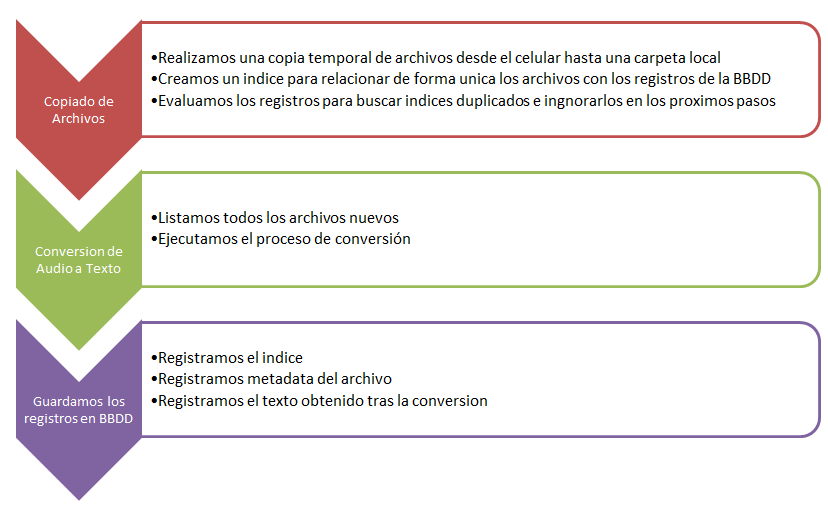

## Proceso de lectura y busqueda

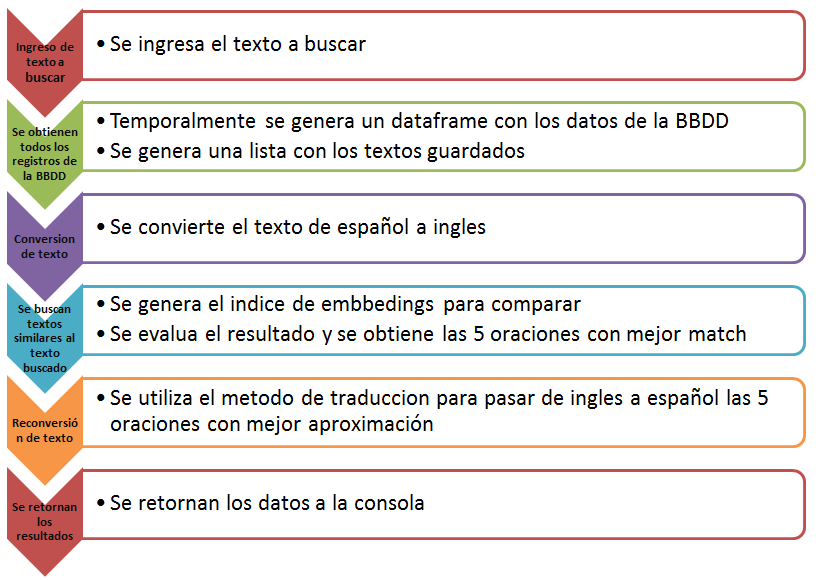